# Import Libraries and Data

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.simplefilter("ignore")

In [2]:
customer = pd.read_csv('/kaggle/input/retail-fashion-data/customer_data.csv')
product = pd.read_csv('/kaggle/input/retail-fashion-data/product_data.csv')
sales = pd.read_csv('/kaggle/input/retail-fashion-data/sales_data.csv')
store = pd.read_csv('/kaggle/input/retail-fashion-data/store_data.csv')

# Data Summary

In [3]:
def check(df):
    """
    Generates a concise summary of DataFrame columns.
    """
    # Compute values that are constant across columns
    total_rows = len(df)
    duplicates = df.duplicated().sum()

    # Use vectorized operations 
    dtypes = df.dtypes
    instances = df.count()
    unique = df.nunique()
    sum_null = df.isnull().sum()
    #null_percentage = (df.isnull().sum() / total_rows * 100).round(2)

    # Create the summary 
    df_check = pd.DataFrame({
        'column': df.columns,
        'dtype': dtypes,
        'instances': instances,
        'unique': unique,
        'sum_null': sum_null,
        #'null_percentage': null_percentage,
        'duplicates': duplicates  
    })

    return df_check

print("Customer Data")
display(check(customer))
display(customer.head())

print("Product Data")
display(check(product))
display(product.head())

print("Sales Data")
display(check(sales))
display(sales.head())

print("Store Data")
display(check(store))
display(store.head())

Customer Data


,column,dtype,instances,unique,sum_null,duplicates
customer_id,customer_id,object,2500,2500,0,0
age,age,int64,2500,54,0,0
gender,gender,object,2500,4,0,0
city,city,object,2500,5,0,0
email,email,object,2450,2450,50,0


,customer_id,age,gender,city,email
0,C00001,20,Female,Faro,user1@example.com
1,C00002,35,Male,Porto,user2@example.com
2,C00003,53,Other,Porto,user3@example.com
3,C00004,52,Female,Porto,NaN
4,C00005,32,Other,Lisbon,user5@example.com


Product Data


,column,dtype,instances,unique,sum_null,duplicates
product_id,product_id,object,5000,5000,0,0
category,category,object,5000,6,0,0
color,color,object,4900,6,100,0
size,size,object,5000,5,0,0
season,season,object,5000,4,0,0
supplier,supplier,object,5000,4,0,0
cost_price,cost_price,float64,5000,3606,0,0
list_price,list_price,float64,5000,4428,0,0


,product_id,category,color,size,season,supplier,cost_price,list_price
0,P00001,Bottoms,Yellow,XL,Summer,supplierc,27.66,114.26
1,P00002,Accessories,Yellow,S,Winter,supplierd,71.70,40.15
2,P00003,Tops,Blue,XS,Summer,supplierc,62.39,63.73
3,P00004,Accessories,Green,M,Fall,suppliera,32.73,68.33
4,P00005,Accessories,White,L,Summer,supplierd,17.53,51.66


Sales Data


,column,dtype,instances,unique,sum_null,duplicates
transaction_id,transaction_id,object,5000,5000,0,0
date,date,object,5000,601,0,0
product_id,product_id,object,5000,3165,0,0
store_id,store_id,object,5000,6,0,0
customer_id,customer_id,object,4801,2152,199,0
quantity,quantity,int64,5000,4,0,0
discount,discount,float64,4767,4,233,0
returned,returned,int64,5000,2,0,0


,transaction_id,date,product_id,store_id,customer_id,quantity,discount,returned
0,T000001,2022-09-13,P04687,S004,C02488,4,0.1,1
1,T000002,2022-05-08,P02631,S004,C01553,1,0.1,0
2,T000003,2023-03-07,P04644,S002,C00093,3,0.0,1
3,T000004,2022-09-19,P04654,S003,C01614,1,0.2,0
4,T000005,2023-05-25,P00224,S003,NaN,4,NaN,0


Store Data


,column,dtype,instances,unique,sum_null,duplicates
store_id,store_id,object,5,5,0,0
store_name,store_name,object,5,5,0,0
region,region,object,5,5,0,0
store_size_m2,store_size_m2,int64,5,5,0,0


,store_id,store_name,region,store_size_m2
0,S001,Lisbon Flagship,Lisbon,768
1,S002,Porto Center,Porto,162
2,S003,Faro Outlet,Algarve,782
3,S004,Online,Online,538
4,S005,Coimbra Boutique,Coimbra,646


# Merge Dataframes 

In [4]:
# Join Strategy how="left": Keeps all transactions, even if product/store/customer has invalid/missing IDs.

# Merge sales with product info
merged_df = sales.merge(product, on="product_id", how="left")

# Merge store info
merged_df = merged_df.merge(store, on="store_id", how="left")

# Merge customer info
merged_df = merged_df.merge(customer, on="customer_id", how="left")
# Check first 5 rows
#merged_df.head()

# Cleaning Pipeline 🧹

In [5]:
import re #regex

class CleaningPipeline:
    """
    A reusable data cleaning pipeline for retail transaction datasets.

    This pipeline:
    1. Standardizes column names
    2. Converts data types
    3. Handles missing values
    4. Removes duplicates
    5. Applies sanity checks and filters invalid data
    6. Normalizes categorical variables
    7. Engineers useful features (revenue, profit, date components)
    8. Validates email addresses 
    
    """

    def __init__(self):
        # Can add params later (e.g., custom imputations, thresholds)
        pass

    def _standardize_column_names(self, df: pd.DataFrame) -> pd.DataFrame:
        """Standardize column names: lowercase, replace spaces/specials with underscores."""
        df = df.copy()
        df.columns = (
            df.columns.str.strip()
            .str.lower()
            .str.replace(r'[^a-z0-9]+', '_', regex=True)
        )
        return df

    def _convert_types(self, df: pd.DataFrame) -> pd.DataFrame:
        """Convert columns to appropriate types where possible."""
        df = df.copy()
        # Date conversion
        if 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date'], errors='coerce')

        # Numeric conversions
        numeric_cols = ['quantity', 'discount', 'cost_price', 'list_price', 'store_size_m2', 'age']
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        # Returned: integer / boolean
        if 'returned' in df.columns:
            df['returned'] = df['returned'].astype('Int64')

        return df

    def _handle_missing(self, df: pd.DataFrame) -> pd.DataFrame:
        """Fill or impute missing values based on business rules."""
        df = df.copy()

        # Discount: assume 0 if missing
        if 'discount' in df.columns:
            df['discount'] = df['discount'].fillna(0.0)

        # Gender: Unknown if missing
        if 'gender' in df.columns:
            df['gender'] = df['gender'].fillna('Unknown')

        # Age: median imputation
        if 'age' in df.columns:
            median_age = df['age'].median()
            df['age'] = df['age'].fillna(median_age)

        # Customer ID & Email: Unknown if missing
        for col in ['customer_id', 'email']:
            if col in df.columns:
                df[col] = df[col].fillna('Unknown')

        return df

    def _deduplicate(self, df: pd.DataFrame) -> pd.DataFrame:
        """Drop duplicates and ensure transaction_id uniqueness."""
        df = df.copy()
        df = df.drop_duplicates()

        if 'transaction_id' in df.columns:
            if not df['transaction_id'].is_unique:
                raise ValueError("Duplicate transaction_id values detected.")

        return df

    def _apply_sanity_checks(self, df: pd.DataFrame) -> pd.DataFrame:
        """Filter rows with invalid values based on logical constraints."""
        df = df.copy()

        if 'quantity' in df.columns:
            df = df[df['quantity'] > 0]

        if 'discount' in df.columns:
            df = df[(df['discount'] >= 0) & (df['discount'] <= 1)]

        if set(['cost_price', 'list_price']).issubset(df.columns):
            df = df[df['cost_price'] < df['list_price']]

        if 'age' in df.columns:
            df = df[(df['age'] >= 12) & (df['age'] <= 100)]

        return df

    def _normalize_categoricals(self, df: pd.DataFrame) -> pd.DataFrame:
        """Standardize categorical text formatting."""
        df = df.copy()
        categorical_cols = [
            'category', 'color', 'gender', 'region',
            'store_name', 'city', 'supplier'
        ]

        for col in categorical_cols:
            if col in df.columns:
                df[col] = df[col].astype(str).str.strip().str.title()
                
        # Supplier normalization
        if 'supplier' in df.columns:
            df['supplier'] = (
                df['supplier']
                .str.strip()
                .str.lower()
                .str.replace(r'[^a-z0-9]+', '', regex=True)  # remove special chars
                .str.replace(r'supplier', 'Supplier_', regex=False)
                .str.replace(r'([a-z])$', lambda m: m.group(1).upper(), regex=True)  #last char to uppercase
            )

        return df

    def _feature_engineering(self, df: pd.DataFrame) -> pd.DataFrame:
        """Create additional features for analysis."""
        df = df.copy()

        if set(['list_price', 'quantity', 'discount']).issubset(df.columns):
            df['revenue'] = df['list_price'] * df['quantity'] * (1 - df['discount'])

        if set(['list_price', 'cost_price', 'quantity']).issubset(df.columns):
            df['profit'] = (df['list_price'] - df['cost_price']) * df['quantity']

        if 'date' in df.columns:
            df['year'] = df['date'].dt.year
            df['month'] = df['date'].dt.month
            df['weekday'] = df['date'].dt.day_name()

        return df

    def _validate_emails(self, df: pd.DataFrame) -> pd.DataFrame:
        """Flag valid/invalid email addresses."""
        df = df.copy()

        if 'email' in df.columns:
            df['valid_email'] = df['email'].apply(
                lambda x: bool(re.match(r"[^@]+@[^@]+\.[^@]+", str(x)))
            )

        return df

    def fit(self, df: pd.DataFrame):
        """
        Fit method included for compatibility.
        (Currently unused, but can be extended if fitting is required.)
        """
        return self

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """Apply all cleaning steps in sequence."""
        df = df.copy()
        df = self._standardize_column_names(df)
        df = self._convert_types(df)
        df = self._handle_missing(df)
        df = self._deduplicate(df)
        df = self._apply_sanity_checks(df)
        df = self._normalize_categoricals(df)
        df = self._feature_engineering(df)
        df = self._validate_emails(df)
        df = df.reset_index(drop=True)
        return df

    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """Fit and transform in a single step."""
        return self.fit(df).transform(df)

In [6]:
# Initialize pipeline
pipeline = CleaningPipeline()

# Clean data
cleaned_df = pipeline.fit_transform(merged_df)

# Check first 5 rows
cleaned_df.head()

,transaction_id,date,product_id,store_id,customer_id,quantity,discount,returned,category,color,...,age,gender,city,email,revenue,profit,year,month,weekday,valid_email
0,T000001,2022-09-13,P04687,S004,C02488,4,0.1,1,Bottoms,White,...,19.0,Male,Coimbra,user2488@example.com,502.452,523.12,2022,9,Tuesday,True
1,T000002,2022-05-08,P02631,S004,C01553,1,0.1,0,Shoes,Red,...,30.0,Female,Lisbon,user1553@example.com,148.878,129.91,2022,5,Sunday,True
2,T000003,2023-03-07,P04644,S002,C00093,3,0.0,1,Tops,White,...,19.0,Other,Lisbon,Unknown,365.130,190.14,2023,3,Tuesday,False
3,T000004,2022-09-19,P04654,S003,C01614,1,0.2,0,Dresses,Blue,...,47.0,Male,Porto,user1614@example.com,100.824,103.10,2022,9,Monday,True
4,T000005,2023-05-25,P00224,S003,Unknown,4,0.0,0,Bottoms,White,...,43.0,Unknown,Nan,Unknown,579.440,406.08,2023,5,Thursday,False


In [7]:
num_rows = (cleaned_df["category"] == "???").sum()
print(num_rows)

48


# Visual Insights

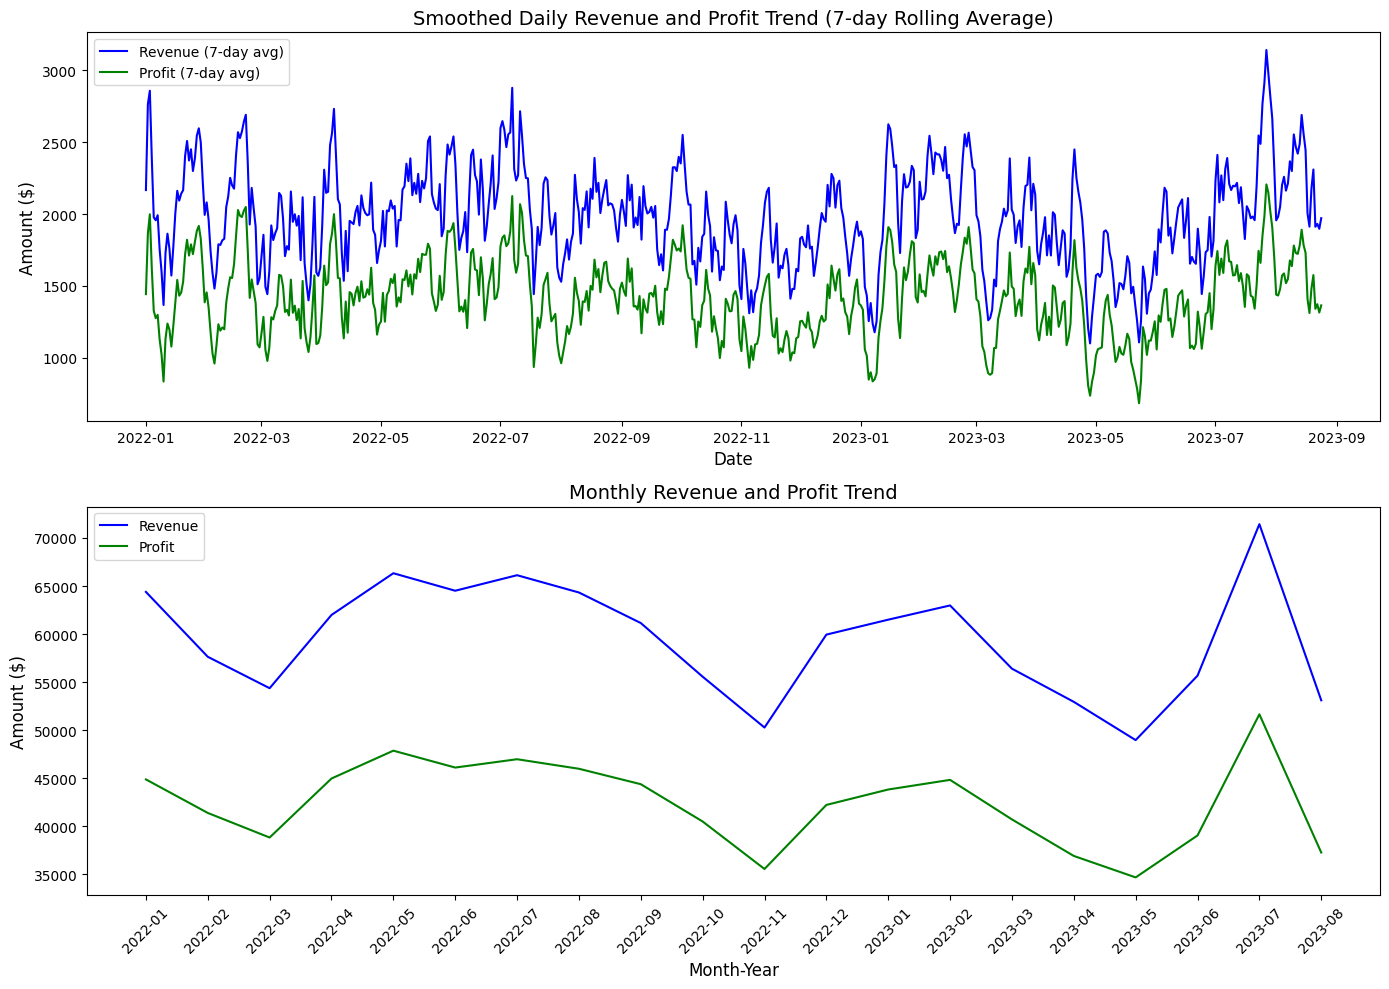

In [8]:
# Aggregate daily sales
daily = cleaned_df.groupby('date')[['revenue', 'profit']].sum().reset_index()

# Calculate 7-day rolling averages
daily['revenue_rolling'] = daily['revenue'].rolling(window=7, min_periods=1).mean()
daily['profit_rolling'] = daily['profit'].rolling(window=7, min_periods=1).mean()

# Aggregate by month
daily['month_year'] = daily['date'].dt.to_period('M').astype(str)  # Convert to string
monthly = daily.groupby('month_year')[['revenue', 'profit']].sum().reset_index()

# Create one figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=False)

# Plot smoothed daily data on first subplot
sns.lineplot(data=daily, x='date', y='revenue_rolling', label='Revenue (7-day avg)', color='blue', ax=axs[0])
sns.lineplot(data=daily, x='date', y='profit_rolling', label='Profit (7-day avg)', color='green', ax=axs[0])
axs[0].set_title("Smoothed Daily Revenue and Profit Trend (7-day Rolling Average)", fontsize=14)
axs[0].set_xlabel("Date", fontsize=12)
axs[0].set_ylabel("Amount ($)", fontsize=12)
axs[0].legend()

# Plot monthly aggregated data on second subplot
sns.lineplot(data=monthly, x='month_year', y='revenue', label='Revenue', color='blue', ax=axs[1])
sns.lineplot(data=monthly, x='month_year', y='profit', label='Profit', color='green', ax=axs[1])
axs[1].set_title("Monthly Revenue and Profit Trend", fontsize=14)
axs[1].set_xlabel("Month-Year", fontsize=12)
axs[1].set_ylabel("Amount ($)", fontsize=12)
axs[1].tick_params(axis='x', rotation=45)
axs[1].legend()

plt.tight_layout()
plt.show()

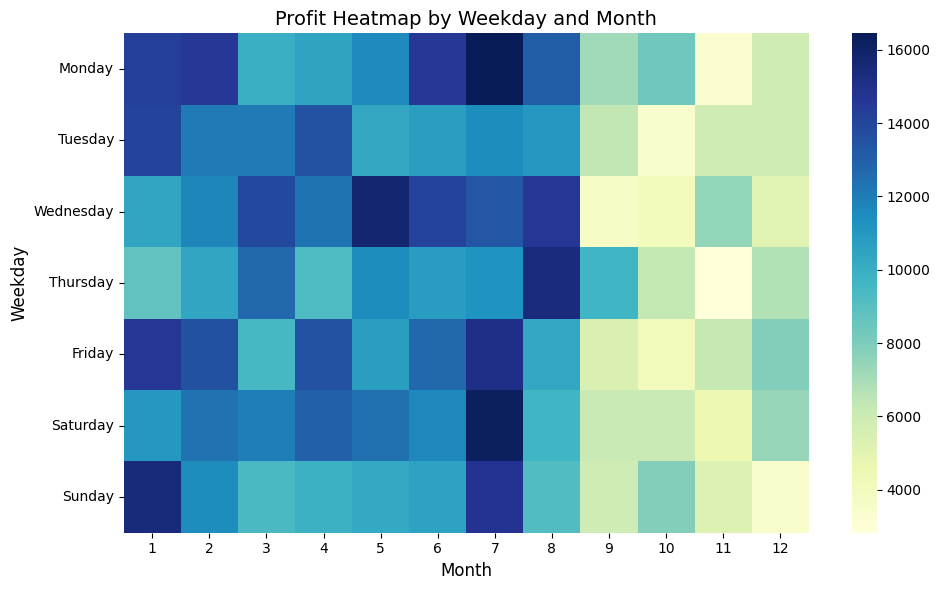

In [9]:
# Define the correct order of weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Ensure 'weekday' is categorical with the specified order
cleaned_df['weekday'] = pd.Categorical(cleaned_df['weekday'], categories=weekday_order, ordered=True)

# Group by weekday and month, then create the heatmap
heat = cleaned_df.groupby(['weekday', 'month'])['profit'].sum().unstack()

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heat, cmap='YlGnBu', annot=False, fmt='.0f')
plt.title("Profit Heatmap by Weekday and Month", fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Weekday', fontsize=12)
plt.tight_layout()
plt.show()

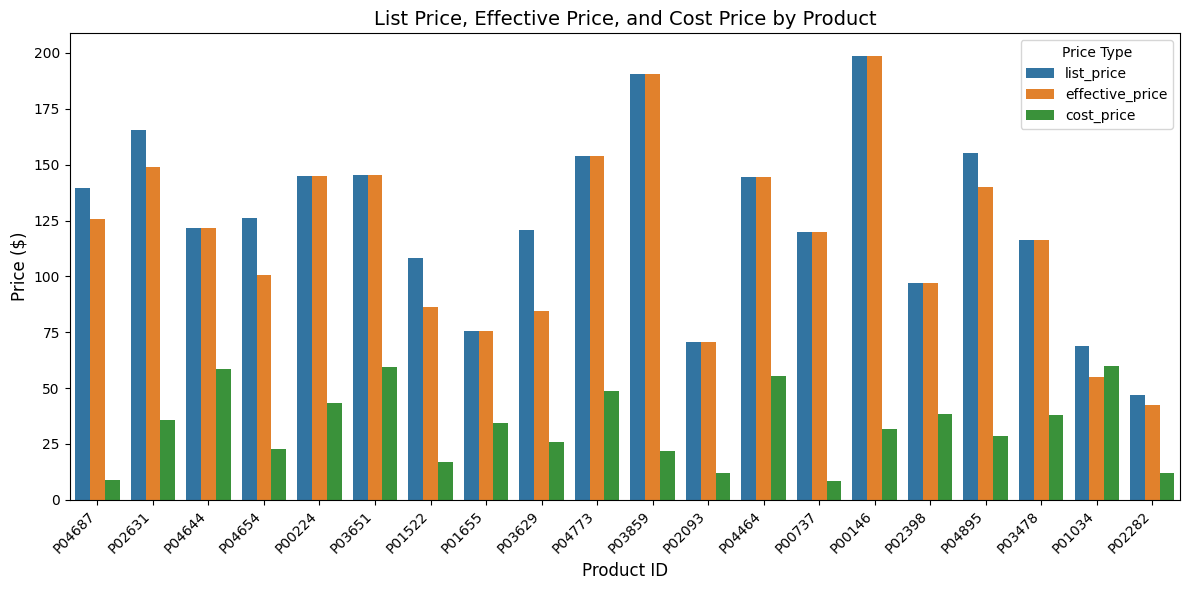

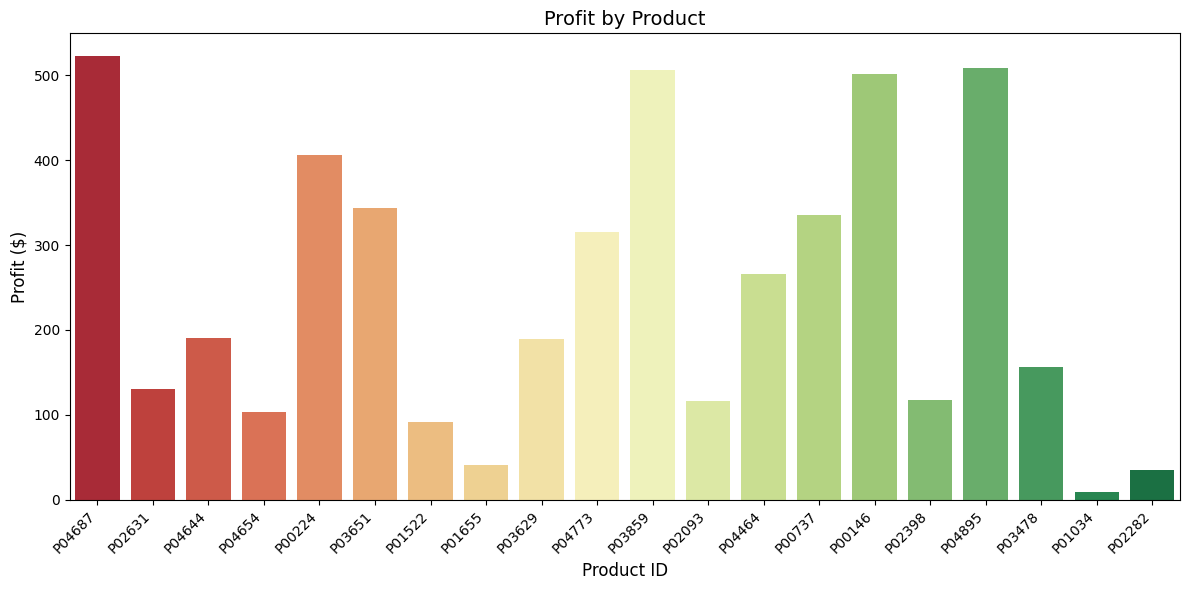

In [10]:
# Calculate effective selling price
cleaned_df['effective_price'] = cleaned_df['revenue'] / cleaned_df['quantity']

# Select a sample of products for clarity (e.g., first 20 unique products)
sample_products = cleaned_df[['product_id', 'list_price', 'effective_price', 'cost_price', 'profit']].drop_duplicates('product_id').head(20)

# Melt the DataFrame for plotting
melted_df = sample_products.melt(id_vars='product_id', value_vars=['list_price', 'effective_price', 'cost_price'], 
                                 var_name='Price_Type', value_name='Price')

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='product_id', y='Price', hue='Price_Type', data=melted_df)
plt.title('List Price, Effective Price, and Cost Price by Product', fontsize=14)
plt.xlabel('Product ID', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Price Type')
plt.tight_layout()
plt.show()

# Plot profit separately to avoid scale issues
plt.figure(figsize=(12, 6))
sns.barplot(x='product_id', y='profit', data=sample_products, palette='RdYlGn')
plt.title('Profit by Product', fontsize=14)
plt.xlabel('Product ID', fontsize=12)
plt.ylabel('Profit ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

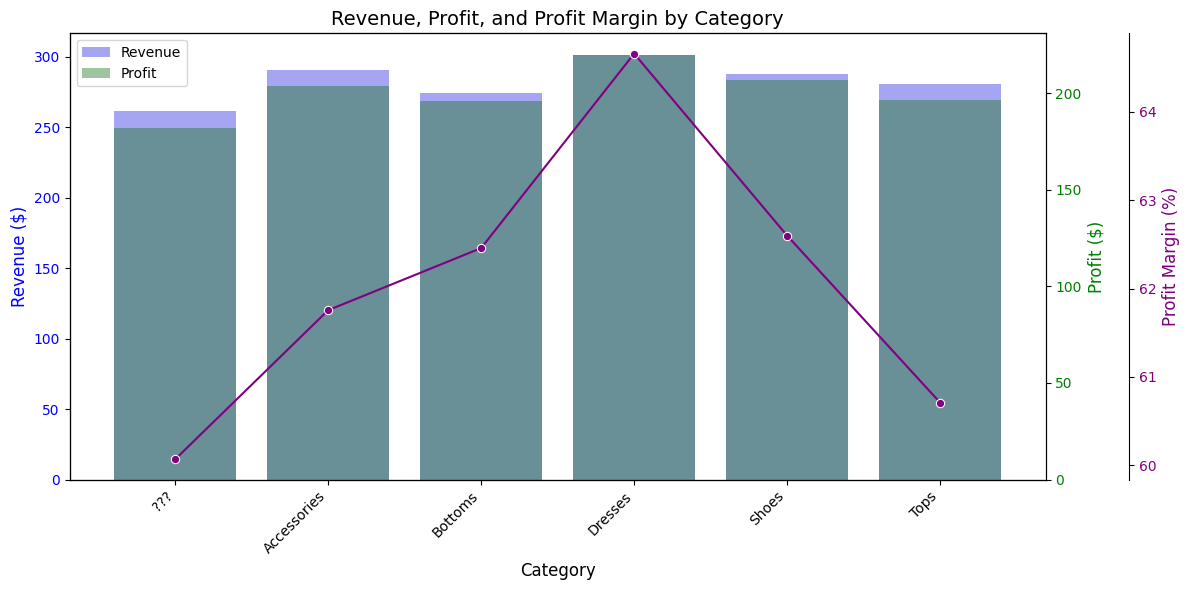

In [11]:
cleaned_df['profit_margin'] = ((cleaned_df['list_price'] - cleaned_df['cost_price']) / cleaned_df['list_price']) * 100
margin_by_supplier = cleaned_df.groupby('supplier')['profit_margin'].mean().sort_values()

# Aggregate by category
category_agg = cleaned_df.groupby('category')[['revenue', 'profit', 'profit_margin']].mean().reset_index()

# Bar plot with dual axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot revenue and profit
sns.barplot(data=category_agg, x='category', y='revenue', color='blue', alpha=0.4, label='Revenue', ax=ax1)
ax1.set_ylabel('Revenue ($)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Category', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Secondary axis for profit
ax2 = ax1.twinx()
sns.barplot(data=category_agg, x='category', y='profit', color='green', alpha=0.4, label='Profit', ax=ax2)
ax2.set_ylabel('Profit ($)', color='green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='green')

# Line plot for profit margin
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset third axis
sns.lineplot(data=category_agg, x='category', y='profit_margin', color='purple', marker='o', ax=ax3)
ax3.set_ylabel('Profit Margin (%)', color='purple', fontsize=12)
ax3.tick_params(axis='y', labelcolor='purple')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left')
plt.title('Revenue, Profit, and Profit Margin by Category', fontsize=14)
plt.tight_layout()
plt.show()

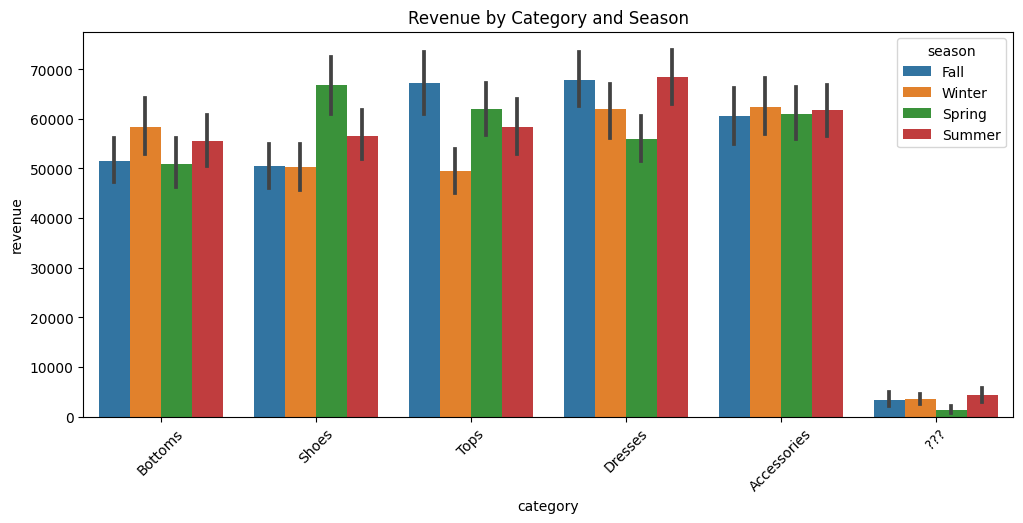

In [12]:
# Revenue by category and season
plt.figure(figsize=(12,5))
sns.barplot(data=cleaned_df, x='category', y='revenue', hue='season', estimator='sum')
plt.title("Revenue by Category and Season")
plt.xticks(rotation=45)
plt.show()

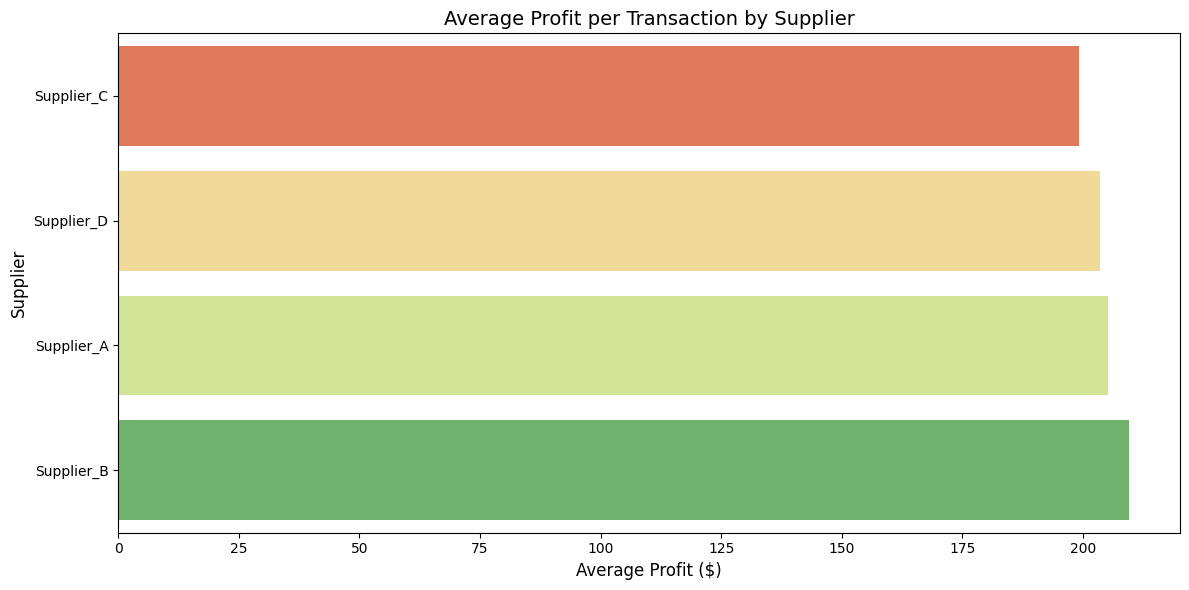

In [13]:
avg_profit_by_supplier = cleaned_df.groupby('supplier')['profit'].mean().sort_values()
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_profit_by_supplier.values, y=avg_profit_by_supplier.index, palette='RdYlGn')
plt.title('Average Profit per Transaction by Supplier', fontsize=14)
plt.xlabel('Average Profit ($)', fontsize=12)
plt.ylabel('Supplier', fontsize=12)
plt.tight_layout()
plt.show()

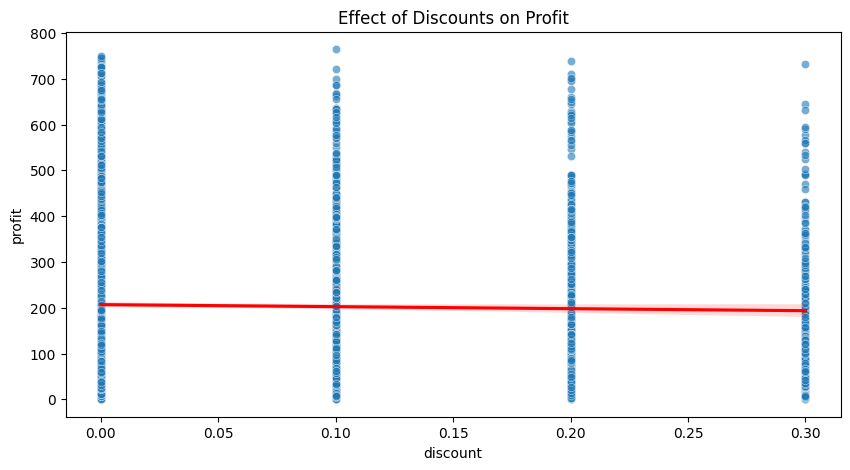

In [14]:
# Discount vs Profit relationship
plt.figure(figsize=(10,5))
sns.scatterplot(data=cleaned_df, x='discount', y='profit', alpha=0.6)
sns.regplot(data=cleaned_df, x='discount', y='profit', scatter=False, color='red')
plt.title("Effect of Discounts on Profit")
plt.show()

**Even at higher discounts (e.g., 0.25–0.30), some transactions still yield profits above 200, suggesting that discounts don't always lead to lower profits and may depend on other factors (e.g., quantity sold, product price).**

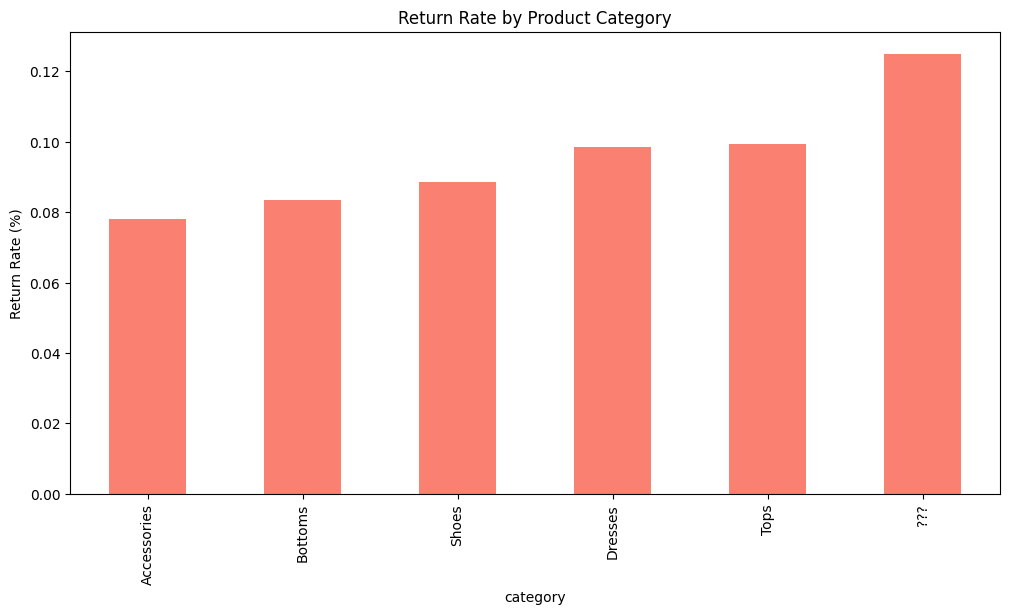

In [15]:
# Return rate by category
returns = cleaned_df.groupby('category')['returned'].mean().sort_values(ascending=True)
returns.plot(kind='bar', figsize=(12,6), color='salmon')
plt.title("Return Rate by Product Category")
plt.ylabel("Return Rate (%)")
plt.show()

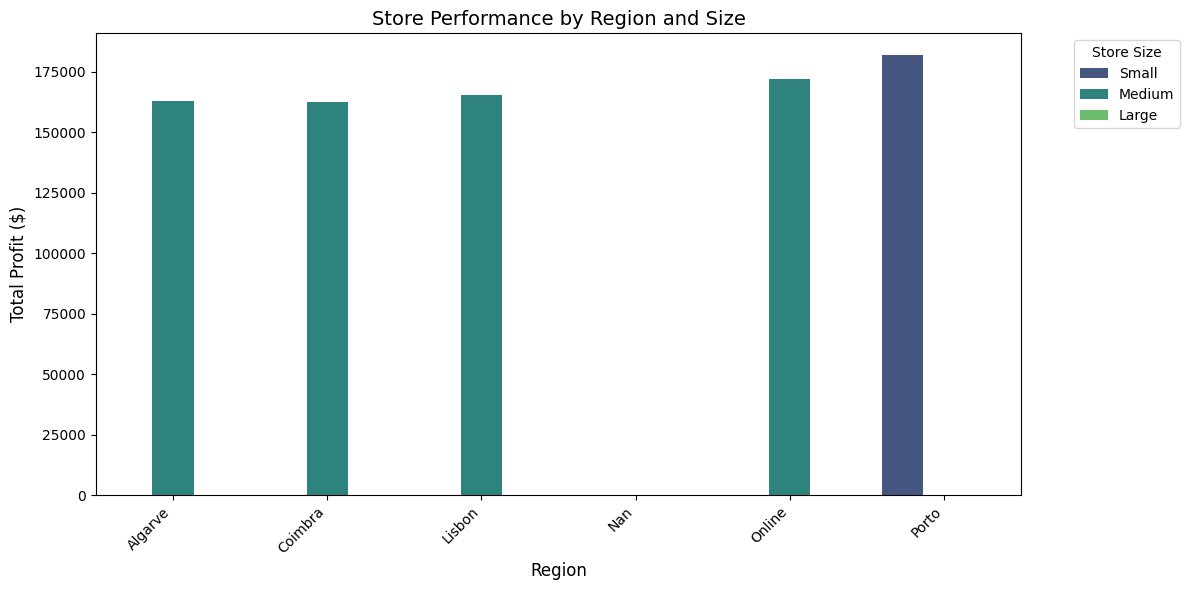

In [16]:
# Bin store_size_m2 into categories (e.g., small, medium, large)
bins = [0, 500, 1000, float('inf')]  # Adjust bins based on data range
labels = ['Small', 'Medium', 'Large']
cleaned_df['size_category'] = pd.cut(cleaned_df['store_size_m2'], bins=bins, labels=labels)

# Aggregate profit by region and size_category
performance_data = cleaned_df.groupby(['region', 'size_category'])['profit'].sum().reset_index()

# Create bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='region', y='profit', hue='size_category', data=performance_data, palette='viridis')

# Customize the plot
plt.title('Store Performance by Region and Size', fontsize=14)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Total Profit ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.legend(title='Store Size', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside
plt.tight_layout()
plt.show()

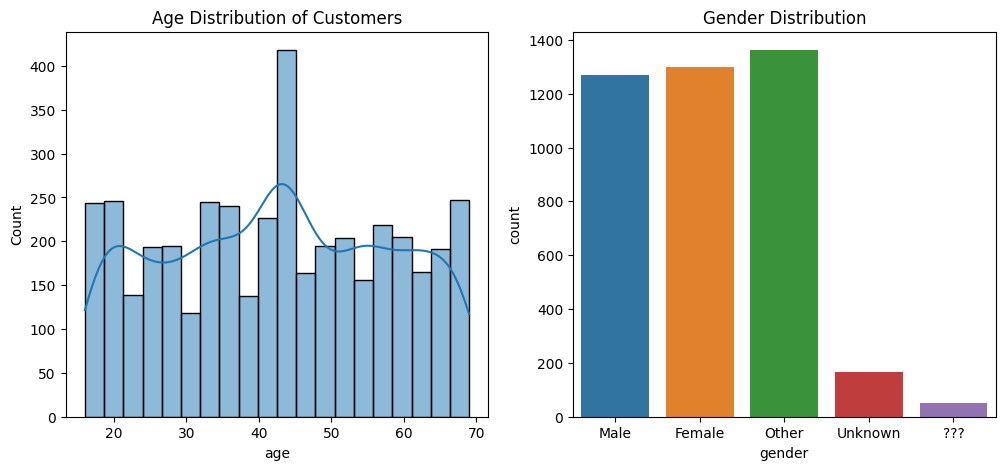

In [17]:
# Customer Demographics
fig, ax = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(cleaned_df['age'], bins=20, kde=True, ax=ax[0])
sns.countplot(data=cleaned_df, x='gender', ax=ax[1])
ax[0].set_title("Age Distribution of Customers")
ax[1].set_title("Gender Distribution")
plt.show()

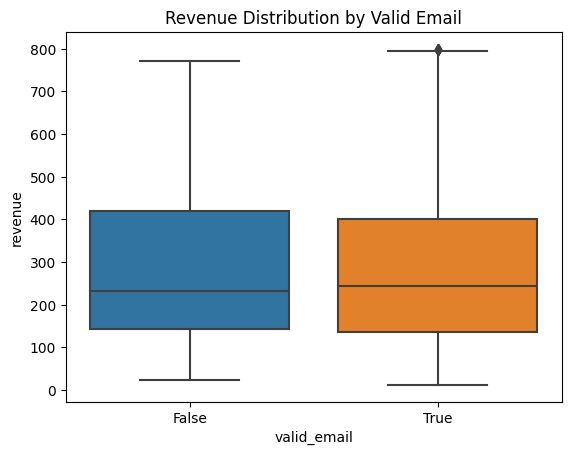

In [18]:
# Email validity vs Revemue
sns.boxplot(data=cleaned_df, x='valid_email', y='revenue')
plt.title("Revenue Distribution by Valid Email")
plt.show()

# Imputing: 
## "???" in category column for funsies

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Separate rows with known and unknown categories
known_data = cleaned_df[cleaned_df['category'] != '???']
unknown_data = cleaned_df[cleaned_df['category'] == '???']

# Prepare features (price) and target (category)
X_train = known_data[['list_price']]  # Feature: price for training
y_train = known_data['category']  # Target: known categories
X_test = unknown_data[['list_price']]  # Feature: price for rows with '???'

# Scale the price feature (important for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train KNN model
knn = KNeighborsClassifier(n_neighbors=3)  # Adjust n_neighbors as needed
knn.fit(X_train_scaled, y_train)

# Predict missing categories
predicted_categories = knn.predict(X_test_scaled)

# Replace '???' with predicted categories
cleaned_df.loc[cleaned_df['category'] == '???', 'category'] = predicted_categories

# Verify the result
print("\nCategory distribution after imputation:")
print(cleaned_df['category'].value_counts())


Category distribution after imputation:
category
Accessories    861
Tops           854
Dresses        848
Bottoms        801
Shoes          785
Name: count, dtype: int64
